# To plot lakes from local data

In [4]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5


fn = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/lake_09999996_GrIS_2020_simplified_GRE_2000_NW_ATL03_20200704015054_01330805_006_01_gt3r_0004.h5'


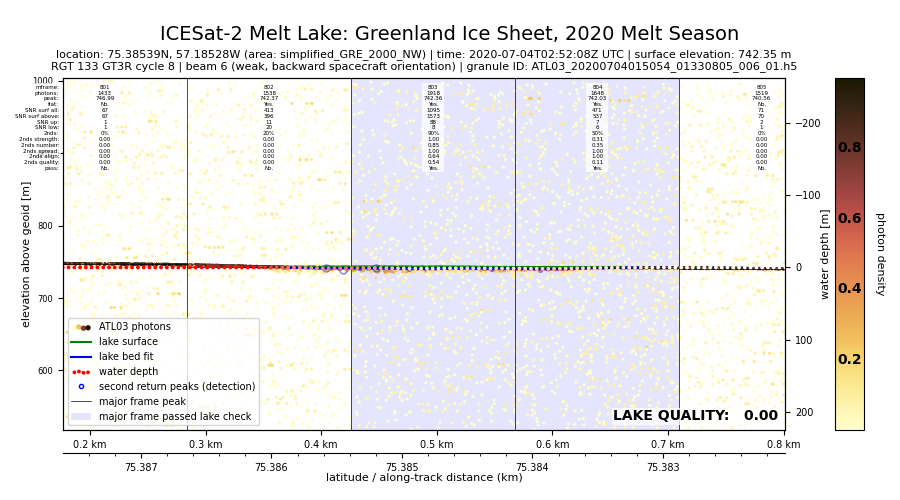

In [62]:
cpath = r"""

"C:\Users\phili\Documents\IceLakesRun2\GlacierLakeDetectionICESat2\lakes_BAD_data\lake_09999996_GrIS_2020_simplified_GRE_2000_NW_ATL03_20200704015054_01330805_006_01_gt3r_0004.h5"

"""

plt.close('all')
base_path = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/detection_out_data/'
pth = cpath
filename = pth[pth.rfind("\\")+1:pth.find('.h5')+3]
filetoplot = base_path+filename
lk = dictobj(read_melt_lake_h5(filetoplot))
print('\n', "fn = '", filetoplot, "'", sep='')
ylm = 'none'
# ylm = 'auto'
fig = lk.plot_lake(set_yl=ylm)

In [2]:
out_path_csv = '/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeDetectionICESat2/GLD1_all_lakes.csv'
df = pd.read_csv(out_path_csv)

In [3]:
df_lakes = df[((df.quality_summary > 0.0) 
               & (df.surface_elevation > 1.0) 
               & (df.max_depth < 50))].copy()
df_lakes.sort_values(by='quality_summary', ascending=False, inplace=True)
len(df_lakes)

7167

In [4]:
sz_sup = 14
sz_tit_l = 12
sz_tit_s = 7
sz_lab_l = 10
sz_lab_s = 6
sz_tck_l = 8
sz_tck_s = 5
colors = {'GrIS': '#D00C33', # Greenland flag
          'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
         }

AIS 24.907569937013683
GrIS 28.61679517625031


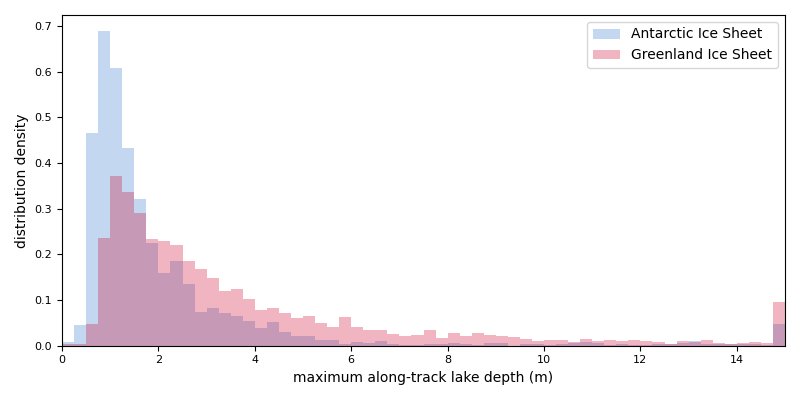

In [5]:
fig, ax = plt.subplots(figsize=[8,4])
step = 0.25
step_s = 0.01
smooth = 1
uplim = 15
hdls = []
for i,sheet in enumerate(['AIS', 'GrIS']):
    dfi = df_lakes[df_lakes.ice_sheet == sheet]
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    print(sheet, dfi.max_depth.max())
    depths = np.clip(dfi.max_depth, 0, uplim-0.01)
    bins = np.arange(0,uplim+step,step)
    mids = bins[:-1] + np.diff(bins)/2
    hist = np.histogram(depths, bins=bins, density=True)[0]
    # bins_s = np.arange(0,uplim+step_s-0.1,step_s)
    # mids_s = bins_s[:-1] + np.diff(bins_s)/2
    # hist_s = np.histogram(depths, bins=bins_s, density=True)[0]
    # wdw = int(np.ceil(smooth/step_s))
    # hist_smooth = pd.Series(hist_s).rolling(window=wdw, center=True, min_periods=1).mean()
    hdl = ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet], alpha=0.3, label=sheet_name)
    hdls.append(hdl)
    # hdl, = ax.plot(mids_s, hist_smooth, color=colors[sheet], label=sheet_name)
    # hdls.append(hdl)
    ax.set_ylabel('distribution density', fontsize=sz_lab_l)
    ax.set_xlabel('maximum along-track lake depth (m)', fontsize=sz_lab_l)
    ax.set_xlim((0,uplim))
    ax.tick_params(axis='both', labelsize=sz_tck_l)

ax.legend(handles=hdls)
fig.tight_layout()

In [6]:
df_depth = df_lakes[df_lakes.ice_sheet=='GrIS'].sort_values(by='quality_summary', ascending=False)
df_depth

,ice_sheet,melt_season,basin,quality_summary,max_depth,length_water_surfaces,surface_elevation,n_photons_where_water,lon,lat,...,cycle_number,rgt,gtx,beam_strength,beam_number,detection_quality,lake_quality,granule_id,lake_id,file_name
0,GrIS,2021,GRE_2000_NE,77.457635,10.387618,2418.0,687.888578,20010,-23.754174,77.516593,...,12,406,gt3r,strong,1,9.385843e-01,82.425150,ATL03_20210720053125_04061205_006_01.h5,simplified_GRE_2000_NE_ATL03_20210720053125_04...,/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeD...
1,GrIS,2019,GRE_2000_CW,69.596755,9.643881,1976.0,1465.033137,10215,-47.768970,69.325233,...,4,658,gt3l,strong,5,9.064291e-01,76.680398,ATL03_20190810040312_06580403_006_02.h5,simplified_GRE_2000_CW_ATL03_20190810040312_06...,/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeD...
2,GrIS,2019,GRE_2000_CW,64.335006,10.971099,1166.0,1140.253463,4982,-49.035769,68.449787,...,4,780,gt3l,strong,5,8.198801e-01,78.367845,ATL03_20190818034635_07800403_006_02.h5,simplified_GRE_2000_CW_ATL03_20190818034635_07...,/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeD...
3,GrIS,2019,GRE_2000_CW,58.123234,12.271634,1562.0,1185.288296,4292,-48.431568,68.981906,...,4,719,gt3l,strong,5,6.386081e-01,90.914068,ATL03_20190814035453_07190403_006_02.h5,simplified_GRE_2000_CW_ATL03_20190814035453_07...,/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeD...
4,GrIS,2019,GRE_2000_CW,55.277714,10.936230,998.0,1261.007606,5008,-49.024466,69.738558,...,4,277,gt1l,strong,1,8.581193e-01,64.316531,ATL03_20190716051841_02770403_006_02.h5,simplified_GRE_2000_CW_ATL03_20190716051841_02...,/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeD...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13923,GrIS,2019,GRE_2000_NO,0.000001,1.188213,379.0,332.230321,9200,-59.112597,80.394496,...,3,1124,gt1l,strong,1,1.434650e-08,0.000000,ATL03_20190610204751_11240304_006_02.h5,simplified_GRE_2000_NO_ATL03_20190610204751_11...,/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeD...
14510,GrIS,2020,GRE_2000_NO,0.000001,1.108627,785.0,1002.121999,13439,-60.786413,79.753630,...,8,240,gt3l,strong,5,1.337209e-08,0.000000,ATL03_20200711015954_02400805_006_01.h5,simplified_GRE_2000_NO_ATL03_20200711015954_02...,/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeD...
15475,GrIS,2022,GRE_2000_NE,0.000001,1.164380,126.0,998.865387,4318,-26.468440,73.978365,...,16,215,gt2r,strong,3,9.075760e-09,0.000000,ATL03_20220705235112_02151603_006_02.h5,simplified_GRE_2000_NE_ATL03_20220705235112_02...,/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeD...
14497,GrIS,2020,GRE_2000_NO,0.000001,3.066759,413.0,671.256927,13883,-64.569151,79.149829,...,8,125,gt2r,weak,4,8.077242e-09,0.000000,ATL03_20200703130601_01250803_006_01.h5,simplified_GRE_2000_NO_ATL03_20200703130601_01...,/Volumes/nox/Philipp/IceLakesRun1/GlacierLakeD...


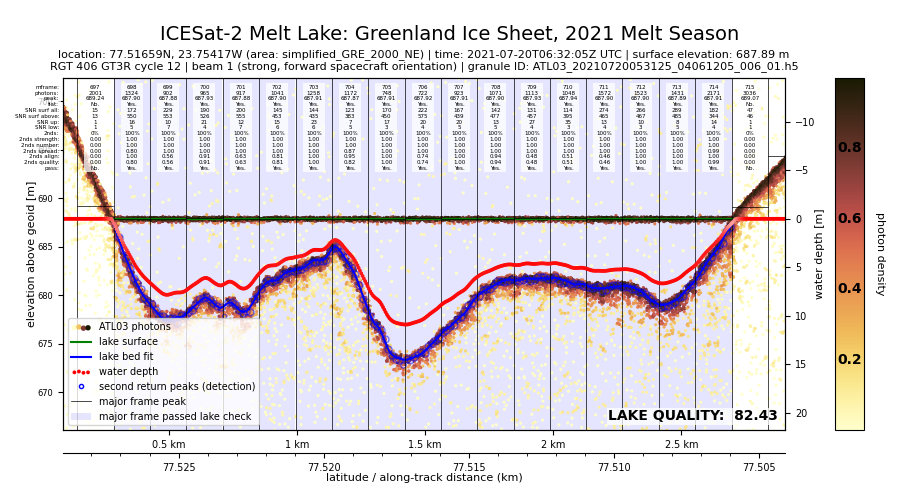

In [7]:
lk = dictobj(read_melt_lake_h5(df_depth.iloc[0].file_name))
fig = lk.plot_lake()

In [33]:
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
lts = [lk.depth_data.lat.min(), lk.depth_data.lat.max()]
lns = [lk.depth_data.lon.min(), lk.depth_data.lon.max()]
ltdf = 0.2 * (lts[1] - lts[0])
lndf = 0.2 * (lns[1] - lns[0])
lts[0] -= ltdf
lts[1] += ltdf
lns[0] -= lndf
lns[1] += lndf
poly = orient(Polygon([(lns[x[0]], lts[x[1]]) for x in [(0,0),(1,0),(1,1),(0,1),(0,0)]]), sign=1.0)
gdf = gpd.GeoDataFrame(geometry=[poly], crs='EPSG:4326')
fn_out = 'geojsons/simplified_test_1_lake.geojson'
gdf.to_file('../GlacierLakeDetectionICESat2/%s'%fn_out, driver='GeoJSON')
gdf.to_file('../GlacierLakeDetectionICESat2/%s'%fn_out.replace('simplified_',''), driver='GeoJSON')
print('./run_py.sh %s %s' % (lk.granule_id, fn_out))

./run_py.sh ATL03_20210720053125_04061205_006_01.h5 geojsons/simplified_test_1_lake.geojson


In [31]:
lk.granule_id

'ATL03_20210720053125_04061205_006_01.h5'

In [ ]:
fig, axs = plt.subplots(figsize=[6,6], ncols=5, nrows=5)
axs = axs.flatten()
basins = np.unique(df_lakes.basin)
# maybe order basins in a reasonable way??

step = 50
for i,basin in enumerate(basins):
    dfi = df_lakes[df_lakes.basin == basin]
    sheet = 'AIS' if basin[:3]=='ANT' else 'GrIS'
    parms = basin.split('_')
    if sheet == 'AIS':
        basin_disp = '%s (%s)' % (parms[3], parms[2])
        basin_name = parms[3]
    else:
        basin_disp = parms[2]
        basin_name = basin_disp

    uplim = 1000 if sheet=='AIS' else 2000
    bins = np.arange(0,uplim+step,step)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(dfi.surface_elevation, bins=bins)[0]
    ax = axs[i]
    ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet])
    ax.set_title(basin_disp, fontsize=sz_tit_s)
    if i%5==0:
        ax.set_ylabel('counts', fontsize=sz_lab_s)
    if i>=20:
        ax.set_xlabel('elevation (m)', fontsize=sz_lab_s)
    ax.set_xlim((0,uplim))
    ax.tick_params(axis='both', labelsize=sz_tck_s)
    
fig.tight_layout(pad=0.2, h_pad=0.5, w_pad=0.5)

In [ ]:
import matplotlib.gridspec as gridspec
sz_sup = 12
sz_tit_l = 10
sz_tit_s = 7
sz_lab_l = 8
sz_lab_s = 6
sz_tck_l = 8
sz_tck_s = 5
colors = {'GrIS': '#D00C33', # Greenland flag
          'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
         }

fig = plt.figure(figsize=[10,10])
spec = gridspec.GridSpec(ncols=10, nrows=15, figure=fig)
axs = []
axs.append(fig.add_subplot(spec[:5, :5]))
axs.append(fig.add_subplot(spec[:5, 5:]))
for i in range(25):
    xloc = 5 + int(i/5)*2
    yloc = (i%5) * 2
    axs.append(fig.add_subplot(spec[xloc:xloc+2, yloc:yloc+2]))

step = 25
for i,sheet in enumerate(['AIS', 'GrIS']):
    dfi = df_lakes[df_lakes.ice_sheet == sheet]
    uplim = 1000 if sheet=='AIS' else 2000
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    bins = np.arange(0,uplim+step,step)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(dfi.surface_elevation, bins=bins)[0]
    ax = axs[i]
    ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet])
    ax.set_title(sheet_name, fontsize=sz_tit_l)
    if i==0:
        ax.set_ylabel('counts of lakes per %i m bin' % step, fontsize=sz_lab_l)
    ax.set_xlabel('elevation above geoid (m)\n', fontsize=sz_lab_l)
    ax.set_xlim((0,uplim))
    ax.tick_params(axis='both', labelsize=sz_tck_l)

basins = np.unique(df_lakes.basin)
# maybe order basins in a reasonable way??
step = 50
for i,basin in enumerate(basins):
    dfi = df_lakes[df_lakes.basin == basin]
    sheet = 'AIS' if basin[:3]=='ANT' else 'GrIS'
    parms = basin.split('_')
    if sheet == 'AIS':
        basin_disp = '%s (%s)' % (parms[3], parms[2])
        basin_name = parms[3]
    else:
        basin_disp = parms[2]
        basin_name = basin_disp

    uplim = 1000 if sheet=='AIS' else 2000
    bins = np.arange(0,uplim+step,step)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(dfi.surface_elevation, bins=bins)[0]
    ax = axs[i+2]
    ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet])
    ax.margins(x=0, y=0)
    # if i%5==0:
    #     ax.set_ylabel('counts', fontsize=sz_lab_s, labelpad=1)
    # if i>=20:
    #     ax.set_xlabel('elevation', fontsize=sz_lab_s, labelpad=1)
    ax.set_xlim((0,uplim))
    ax.tick_params(axis='both', labelsize=sz_tck_s)
    ax.text(0.5, 1.03, basin_disp, fontsize=sz_tit_s, transform=ax.transAxes, ha='center', va='bottom')

fig.suptitle('surface elevation distributions of ICESat-2 lakes', fontsize=sz_sup)
fig.tight_layout(h_pad=0.01, w_pad=0.01)